In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data import WellProcessor, load_data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [4]:
X, y = load_data()
X['target'] = y['status_group']
imputer = SimpleImputer(missing_values = 0,strategy = 'median')
X['construction_year'] = imputer.fit_transform(X[['construction_year']])
X['age'] = X['date_recorded'] - X['construction_year']

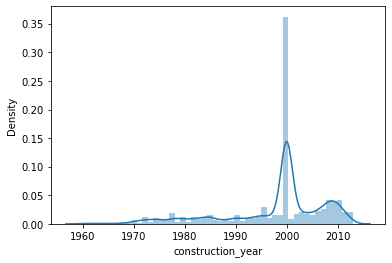

In [5]:
sns.distplot(X['construction_year'])
plt.savefig('figures/construction_distribution.png')

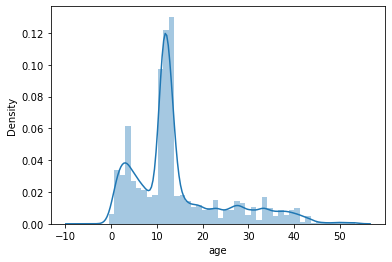

In [6]:
sns.distplot(X['age'])
plt.savefig('figures/age_distribution')

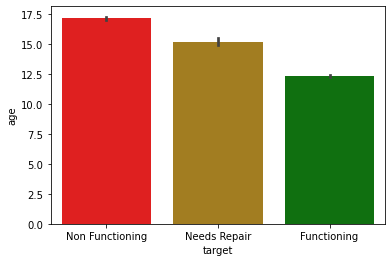

In [14]:
sns.barplot(x=X['target'],y=X['age'], palette = ['red','darkgoldenrod','green'])
plt.xticks(ticks = np.arange(3), labels = ['Non Functioning','Needs Repair','Functioning'])
plt.savefig('figures/age_vs_target')